## 1. Import all required modules

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.preprocessing import sequence, text
from keras.layers import Embedding, Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten

Using TensorFlow backend.


## 2. Load Data

Dataset used: [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/)

In [2]:
data = pd.read_csv('./IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

## 3. Preprocessing reviews

As reviews contain HTML tags, [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) is helpful for getting only the text from reviews.

In [4]:
def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def clean_text(raw_text):
    text = remove_html(raw_text)
    return text

In [5]:
data['review'] = data['review'].apply(clean_text)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 4. Tokenize words in reviews

Consider only 10000 most frequenlty used words (```vocab_size```) in reviews for tokenization and only first 100 words (```max_len```) in a review. 

In [6]:
# maximum number of words to keep, based on word frequency
vocab_size = 10000

tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['review'])
sequences = tokenizer.texts_to_sequences(data['review'])
word_index = tokenizer.word_index

In [7]:
# maximum length of all sequences
max_len = 100

x = sequence.pad_sequences(sequences, maxlen=max_len)

In [8]:
sentiments = {
    'positive': 1,
    'negative': 0
}

y = np.asarray(data['sentiment'].map(sentiments))

## 5. Split data

Split 60% of data for training, 20% of data for cross validation and 20% data for testing. 

In [9]:
train_samples = 40000

x_train = x[:train_samples]
y_train = y[:train_samples]

x_test = x[train_samples:]
y_test = y[train_samples:]

## 6. Load GloVe Embedding Vectors

Load [GloVe](https://nlp.stanford.edu/projects/glove/) file with 100 Dimension vector into ```embedding_index```.

In [10]:
def load_glove(path):
    
    embedding_index = {}
    for line in open(path):
        values = line.split()
        word = values[0]
        coeff = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeff
    
    return embedding_index

In [11]:
embedding_index = load_glove('./glove.6B.100d.txt')

## 7. Prepare embedding matrix

Prepare embedding matrix of shape (```vocab_size```, ```embedding_dim```) using vectors from ```embedding_index```.

In [12]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in word_index.items():
    if index < vocab_size:
        vector = embedding_index.get(word);
        if vector is not None:
            embedding_matrix[index] = embedding_index.get(word)

print('Shape of embedding matrix:', embedding_matrix.shape)

Shape of embedding matrix: (10000, 100)


In [13]:
# check for successful embedding matrix

embedding_matrix[word_index.get('the')] == embedding_index.get('the')

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## 8. Prepare and train models

Prepare model and load weights of ```embedding_matrix``` and set the embedding layer to ```trainable = False```

In [14]:
def get_LSTM_model(units = 32, dropout = 0):
    
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
        LSTM(units, dropout=dropout),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    return model


def get_GRU_model(units = 32, dropout = 0):
    
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
        GRU(units, dropout=dropout),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    return model


def get_CNN_model(filters = 32, filter_size = 7, pool_size = 5):
    
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
        Conv1D(filters, filter_size, activation='relu'),
        MaxPooling1D(pool_size),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [15]:
LSTM_model = get_LSTM_model()
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 17,057
Non-trainable params: 1,000,000
_________________________________________________________________


In [16]:
GRU_model = get_GRU_model()
GRU_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,012,801
Trainable params: 12,801
Non-trainable params: 1,000,000
_________________________________________________________________


In [17]:
CNN_model = get_CNN_model()
CNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 94, 32)            22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 577       
Total params: 1,023,009
Trainable params: 23,009
Non-trainable params: 1,000,000
_________________________________________________________________


In [18]:
epochs = 5
batch_size = 32
val_split = 0.2

In [20]:
LSTM_history = LSTM_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=val_split)
LSTM_model.save('LSTM_imdb_sentiment_analysis.h5')

Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 59s 2ms/step - loss: 0.2986 - acc: 0.8704 - val_loss: 0.3276 - val_acc: 0.8565
Epoch 2/5
32000/32000 [==============================] - 45s 1ms/step - loss: 0.2860 - acc: 0.8765 - val_loss: 0.3265 - val_acc: 0.8580
Epoch 3/5
32000/32000 [==============================] - 50s 2ms/step - loss: 0.2739 - acc: 0.8837 - val_loss: 0.3250 - val_acc: 0.8581
Epoch 4/5
32000/32000 [==============================] - 41s 1ms/step - loss: 0.2595 - acc: 0.8895 - val_loss: 0.3302 - val_acc: 0.8562
Epoch 5/5
32000/32000 [==============================] - 44s 1ms/step - loss: 0.2504 - acc: 0.8935 - val_loss: 0.3386 - val_acc: 0.8537


In [21]:
GRU_history = GRU_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=val_split)
GRU_model.save('GRU_imdb_sentiment_analysis.h5')

Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 51s 2ms/step - loss: 0.4768 - acc: 0.7580 - val_loss: 0.3918 - val_acc: 0.8200
Epoch 2/5
32000/32000 [==============================] - 47s 1ms/step - loss: 0.3684 - acc: 0.8330 - val_loss: 0.3603 - val_acc: 0.8435
Epoch 3/5
32000/32000 [==============================] - 45s 1ms/step - loss: 0.3430 - acc: 0.8465 - val_loss: 0.3441 - val_acc: 0.8482
Epoch 4/5
32000/32000 [==============================] - 47s 1ms/step - loss: 0.3208 - acc: 0.8579 - val_loss: 0.3328 - val_acc: 0.8533
Epoch 5/5
32000/32000 [==============================] - 47s 1ms/step - loss: 0.3024 - acc: 0.8675 - val_loss: 0.3300 - val_acc: 0.8545


In [22]:
CNN_history = CNN_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=val_split)
CNN_model.save('CNN_imdb_sentiment_analysis.h5')

Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 12s 384us/step - loss: 0.5416 - acc: 0.7153 - val_loss: 0.4691 - val_acc: 0.7774
Epoch 2/5
32000/32000 [==============================] - 12s 376us/step - loss: 0.4345 - acc: 0.7997 - val_loss: 0.5733 - val_acc: 0.7204
Epoch 3/5
32000/32000 [==============================] - 12s 376us/step - loss: 0.3982 - acc: 0.8193 - val_loss: 0.4268 - val_acc: 0.8009
Epoch 4/5
32000/32000 [==============================] - 14s 426us/step - loss: 0.3630 - acc: 0.8370 - val_loss: 0.4307 - val_acc: 0.7991
Epoch 5/5
32000/32000 [==============================] - 13s 395us/step - loss: 0.3346 - acc: 0.8531 - val_loss: 0.4927 - val_acc: 0.7797


In [27]:
def plot_graph(history, title = 'accuracy and loss graphs'):
    
    acc_values = history.history['acc']
    val_acc_values = history.history['val_acc']

    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']

    epochs_range = range(1, epochs + 1)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)
    
    ax[0].plot(epochs_range, acc_values, label='Training accuracy')
    ax[0].plot(epochs_range, val_acc_values, label='Validation accuracy')
    ax[0].set(xlabel='Epochs', ylabel='Accuracy')
    ax[0].legend()
    ax[0].set_title('Accuracy')

    ax[1].plot(epochs_range, loss_values, label='Training loss')
    ax[1].plot(epochs_range, val_loss_values, label='Validation loss')
    ax[1].set(xlabel='Epochs', ylabel='Loss')
    ax[1].legend()
    ax[1].set_title('Loss')

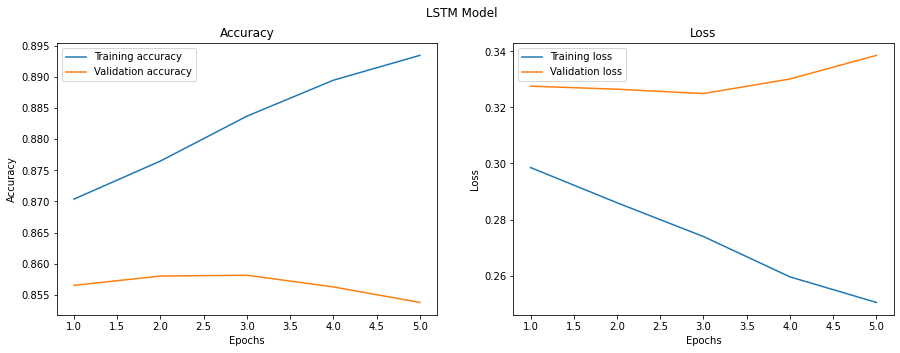

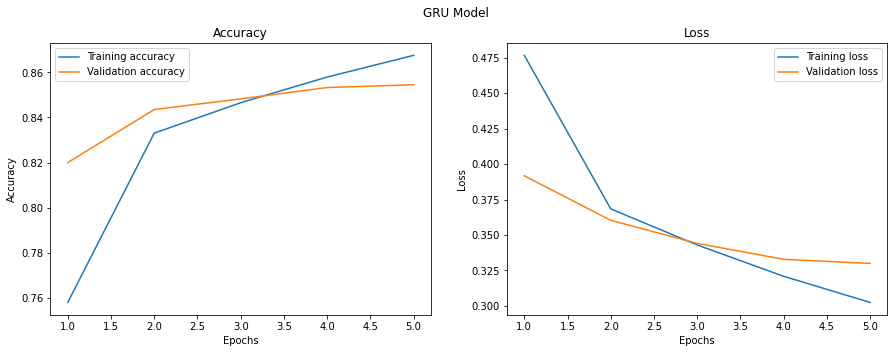

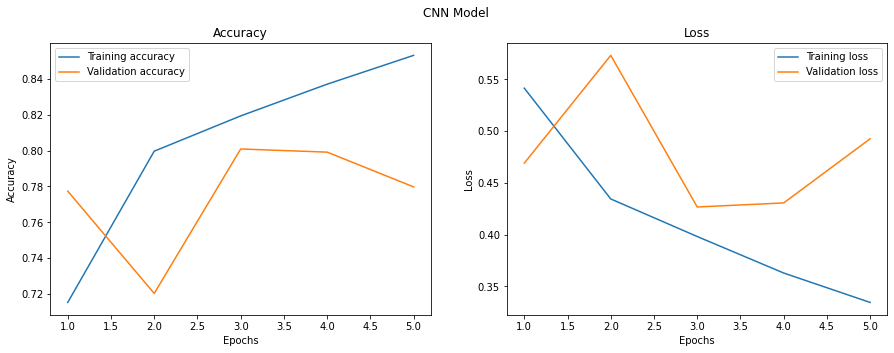

In [28]:
plot_graph(LSTM_history, 'LSTM Model')
plot_graph(GRU_history, 'GRU Model')
plot_graph(CNN_history, 'CNN Model')

## 9. Test models on testing samples

In [25]:
def test_model(model):
    scores = model.evaluate(x_test, y_test)
    print('Loss: {}'.format(scores[0]))
    print('Accuracy: {}'.format(scores[1]))

In [29]:
print('LSTM Model')
test_model(LSTM_model)

LSTM Model
10000/10000 [==============================] - 4s 363us/step
Loss: 0.3411164959669113
Accuracy: 0.8574000000953674


In [30]:
print('GRU Model')
test_model(GRU_model)

GRU Model
10000/10000 [==============================] - 4s 371us/step
Loss: 0.33136503682136537
Accuracy: 0.8550999760627747


In [31]:
print('CNN Model')
test_model(CNN_model)

CNN Model
10000/10000 [==============================] - 1s 119us/step
Loss: 0.47741796178817747
Accuracy: 0.7842000126838684
